In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [4]:
from __future__ import annotations
import networkx as nx
import jaxley as jx
from jaxley.io.swc import read_swc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# This does
- 10x faster import
- reduce error to neuron by 1 order
- refactor / more modular and simplified graph pipeline
- adds NEURON backends

# Questions
- how to determine branch direction (and how loc works)? Along edge direction or with ascending comp / node index?
- How to enumerate compartments? Should branchpoint comps get a comp_index?
- Use DiGraph only for SWC and then Graph?
- do we need solve_graph or traversal in reader?

# TODOS
-[x] pass import / export cycle tests
-[ ] pass `test_swc.py`
-[ ] Remove old and dangling code / refactor

# Follow Up questions / todos
- Keep branchpoints and tip nodes in `nodes` and in graph; introduce `compartments` attribute that only shows compartment nodes? Nodes shows all nodes `cell.nodes.loc[is_comp]`
- better ground-truthing vs NEURON (using graph imports from NEURON)
- simpler indexing "global_branch_index" -> "branch"
- refactor / rewrite set_ncomp (can just rebuild using comp_graph), store_compgraph?
- replace old `compute_xyz` with new version
- with the new graph functionality, this should be much easier to do

## Other Ideas:
### Reformat dataframes
- rename `global_X_index` to `X_index`
- use tuples of nodes to index edges
- treat synapses like groups and channels, i.e. boolean indices

In [5]:
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new

import networkx as nx
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import jax

from warnings import warn


In [6]:
import numpy as np
from neuron import h
from neuron import rxd
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new
from scipy.spatial.distance import cdist
from typing import Callable, Optional
import jax
import jax.numpy as jnp
import pandas as pd
from collections import deque

# Load NEURON stdlib and import3d
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")

unpack_dict = lambda d, keys: np.array([d[k] for k in keys])

def load_swc_with_neuron(fname: str, ncomp: int = 1):
    """
    Load a SWC file and return a NEURON cell object.

    Uses `h.Import3d_SWC_read()` to load the SWC file.

    Args:
        fname: The path to the SWC file.
        ncomp: The number of compartments per segment.
    """
    # Clear existing sections
    for sec in h.allsec():
        h.delete_section(sec=sec)

    # Load and instantiate SWC
    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = ncomp

    return cell

def swc_to_nx_with_neuron(fname: str, merge_branchpoints: bool = False) -> nx.DiGraph:
    """
    Reads from the global `h.allsec()` and writes the attributes to a nx.DiGraph. The 
    edges are created by connecting the first point of a section to the last point of the
    parent section and connecting up each point (line in the SWC file) within a section.
    Each n3d point becomes a node in the graph. 

    The graph is comparable to Jaxley's SWC-Graph and can be used to compare / debug 
    Jaxley's and NEURON's SWC readers.
    
    The node attributes are:
    - label: The node label "SectionName(idx)".
    - id: The SWC type ID.
    - x: The x-coordinate.
    - y: The y-coordinate.
    - z: The z-coordinate.
    - r: The radius.
    - sec_name: The name of the section.

    Returns:
        A nx.DiGraph with the node and edge attributes.
    """
    load_swc_with_neuron(fname)

    # Map section types to SWC type IDs
    type2id = {
        'soma': 1,
        'axon': 2,
        'dend': 3,
        'apic': 4
    }

    nodes, edges = [], []
    for sec in h.allsec():
        sec_name = sec.name()
        sec_type = sec_name.split("[")[0]

        for idx in range(sec.n3d()):
            nodes.append({
                "sec_name": sec_name,
                "label": f"{sec_name}({idx})",
                "x": sec.x3d(idx),
                "y": sec.y3d(idx),
                "z": sec.z3d(idx),
                "r": sec.diam3d(idx) / 2,
                "id": type2id.get(sec_type, 0),
            })
            if idx > 0: # within section edges
                edges += [(nodes[-2]["label"], nodes[-1]["label"])]

        # edges
        if sec.parentseg():
            parent_sec = sec.parentseg().sec
            parent_n3d = parent_sec.n3d()
            prev_sec_end = parent_sec.name() + f"({parent_n3d-1})"
            edges += [(prev_sec_end, sec_name + "(0)")] # between section edges

    nodes_df = pd.DataFrame(nodes)

    edges_df = pd.DataFrame(edges, columns=["i", "j"])
    edges_df = edges_df[edges_df["i"].notna()]

    name_to_index = dict(zip(nodes_df["label"], nodes_df.index))
    edges_df['i'] = edges_df['i'].map(name_to_index)
    edges_df['j'] = edges_df['j'].map(name_to_index)
    edges_df.set_index(["i", "j"], inplace=True)
    edges_df.index.names = [None, None]

    nodes_df.drop(columns=["label"], inplace=True)
    graph = graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series())
    if merge_branchpoints:
        # TODO: find out how to contract branchpoints to mimix jaxley graph 
        # (i.e. which of the merged nodes is the orignal swc node? vs which have 
        # already id and radius modded)
        graph = contract_similar_nodes(graph)
    return graph

def build_solve_graph_with_neuron(fname: str, ncomp: int = 1, drop_neuron_specific_attrs: bool = True) -> nx.DiGraph:
    """
    Reads from the global `h.allsec()` and constructs a compartment graph from the ingested
    SWC file. Each section is divided into `ncomp` compartments and each compartment will
    become a node in the graph. Each node will contain the attributes that are used to
    simulate each compartment.

    The graph is comparable to Jaxley's Compartment-Graph and can be used to compare / debug 
    Jaxley's and NEURON's SWC readers. Especially how NEURON and Jaxley handle computation
    of the compartment / segment attributes, like radius, volume, surface area, etc.

    The node attributes are:
    - comp_index: The compartment index.
    - seg_name: The name of the segment. (neuron specific)
    - sec_name: The name of the section. (neuron specific)
    - x: The x-coordinate.
    - y: The y-coordinate.
    - z: The z-coordinate.
    - radius: The radius.
    - area: The area.
    - surface_area: The surface area.
    - volume: The volume.
    - length: The length.
    - groups: The groups.

    Returns:
        A nx.DiGraph with the node and edge attributes.
    """
    load_swc_with_neuron(fname)
    for sec in h.allsec():
        sec.nseg = ncomp

    data = []
    segment_indices = {}
    compartment_index = 0

    type2id = {
        "soma": 1,
        "axon": 2,
        "dend": 3,
        "apic": 4
    }

    # Dummy cytosolic region
    cyt = rxd.Region(h.allsec(), name='cyt')

    # Create a dummy species to get access to segment volumes
    ca = rxd.Species(cyt, name='ca', d=0)
    seg2node = {str(node.segment): node for node in ca.nodes}

    # collect node data and assign segment indices
    graph_attrs = {"xyzr": [], "branchpoints_and_tips": []}
    seg_edges = []
    for sec in h.allsec():
        sec_name = sec.name()

        n3d = sec.n3d()
        arc = np.array([sec.arc3d(i) for i in range(n3d)]) # Cumulative arc lengths 
        norm_arc = arc / arc[-1]
        x3d = np.array([sec.x3d(i) for i in range(n3d)]) 
        y3d = np.array([sec.y3d(i) for i in range(n3d)]) 
        z3d = np.array([sec.z3d(i) for i in range(n3d)]) 
        r3d = np.array([sec.diam3d(i) / 2 for i in range(n3d)]) 
        xyzr = np.array([x3d, y3d, z3d, r3d]).T 
        
        for seg_idx, seg in enumerate(sec):
            seg_name = str(seg)
            node = seg2node.get(seg_name)
            radius = seg.diam / 2
            length = sec.L / sec.nseg
            area = seg.area()
            type_name = sec_name.split("[")[0]

            data.append({
                "comp_index": compartment_index,
                "seg_name": seg_name,
                "sec_name": sec_name,
                "x": np.interp(seg.x, norm_arc, x3d),
                "y": np.interp(seg.x, norm_arc, y3d),
                "z": np.interp(seg.x, norm_arc, z3d),
                "r": radius,
                "area": node.surface_area,
                "volume": node.volume,
                "l": length,
                "id": type2id.get(type_name, "unknown"),
                "resistive_load_in": length / 2 / radius ** 2 / np.pi,
                "resistive_load_out": length / 2 / radius ** 2 / np.pi,
            })
            graph_attrs["xyzr"].append(xyzr)
            compartment_index += 1
            
            if seg_idx > 0:
                seg_edges += [(data[-2]["seg_name"], data[-1]["seg_name"])] # within branch

        # edges
        if sec.parentseg():
            parent_sec = sec.parentseg().sec
            prev_sec_end = str(deque(iter(parent_sec), maxlen=1).pop())
            start_seg = str(next(iter(sec)))
            seg_edges += [(prev_sec_end, start_seg)] # between branches

    # Create DataFrames
    nodes_df = pd.DataFrame(data).set_index("comp_index")
    branch_indices = {sec.name(): i for i, sec in enumerate(h.allsec())}
    nodes_df["branch_index"] = nodes_df["sec_name"].map(branch_indices)
    nodes_df["is_comp"] = True
    nodes_df["cell_index"] = 0

    edges_df = pd.DataFrame(seg_edges, columns=["i", "j"])
    edges_df = edges_df[edges_df["i"].notna()]

    name_to_index = dict(zip(nodes_df["seg_name"], nodes_df.index))
    edges_df['i'] = edges_df['i'].map(name_to_index)
    edges_df['j'] = edges_df['j'].map(name_to_index)

    source_branches = nodes_df.loc[edges_df["i"], "branch_index"].values
    target_branches = nodes_df.loc[edges_df["j"], "branch_index"].values
    edges_df["branch_edge"] = (source_branches != target_branches)
    edges_df["comp_edge"] = True
    edges_df["synapse"] = False

    edges_df.set_index(["i", "j"], inplace=True)
    edges_df.index.names = [None, None]

    if drop_neuron_specific_attrs:
        nodes_df = nodes_df.drop(columns=["seg_name", "sec_name"])

    graph = graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series(graph_attrs))
    graph = graph_io_new._add_jaxley_meta_data(graph)
    nx.set_node_attributes(graph, {n: int(d["comp_index"]) for n,d in graph.nodes(data=True)}, "comp_index")

    return graph

def contract_similar_nodes(G, attrs=['x', 'y', 'z'], relabel_nodes=False, merge_rule=None):
    nodes = list(G.nodes())
    node_attrs = [list(nx.get_node_attributes(G, attr).values()) for attr in attrs]
    node_attrs = np.array(node_attrs).T

    dists = cdist(node_attrs, node_attrs)
    merge_pairs = np.where(np.isclose(dists, 0))
    merge_pairs = [(nodes[i], nodes[j]) for i, j in zip(*merge_pairs) if i < j]
    merge_groups = nx.Graph()
    merge_groups.add_edges_from(merge_pairs)
    sets = nx.connected_components(merge_groups) # get disjoint sets of nodes

    if merge_rule is None:
        merge_rule = lambda x: (list(x.nodes)[0], list(x.nodes())[1:])
    
    for set in sets:
        keep_node, rm_nodes = merge_rule(G.subgraph(set))
        for remove_node in rm_nodes:
            G = nx.contracted_nodes(G, keep_node, remove_node, self_loops=False, copy=False)
            del G.nodes[keep_node]["contraction"]
    
    if relabel_nodes:
        G = nx.relabel_nodes(G, {n: i for i, n in enumerate(G.nodes())})
    return G

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle

def graph_vis(graph, dims=(0, 1), ax=None, show_radii=False, jitter=0.0, scale_radii=1.0, radii_kwargs={}, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    add_jitter = lambda x: x + np.random.uniform(-jitter, jitter, size=len(x))
    pos = {
        k: add_jitter(np.array([data["xyz"[d]] for d in dims]))
        for k, data in graph.nodes(data=True)
    }

    nx.draw(graph, pos=pos, ax=ax, **kwargs)

    if show_radii:
        patch_kwargs = dict(edgecolor="C3", facecolor="none", linewidth=1.0, zorder=3)
        patch_kwargs.update(radii_kwargs)

        for k, data in graph.nodes(data=True):
            r = data.get("radius", data.get("r", None))
            R = float(r) * float(scale_radii)
            ax.add_patch(Circle(pos[k], R, **patch_kwargs))

    return ax

def neuron_list_branches(swc_graph: nx.DiGraph) -> list[list[int]]:
    """Creates a list of branches / sections from a NEURON SWC graph.

    This returns the compartment indices (same as the node indices in the compartment graph)
    for each branch / section in the NEURON SWC graph.

    Args:
        swc_graph: A NEURON SWC graph (created with `neuron_swc_graph()`).

    Returns:
        A list of lists, where each sublist contains the compartment indices for a branch
        and the index of each list corresponds to the branch index.
    """
    secs = nx.get_node_attributes(swc_graph, "sec_name")
    branches = {k: [] for k in secs.values()}
    for k, v in secs.items():
        branches[v].append(k)
    return list(branches.values())

def old_list_branches(swc_graph, ignore_swc_tracing_interruptions=True):
    traced_branches = []
    mod_graph, branches, *_ = graph_io_old._trace_branches(swc_graph, ignore_swc_tracing_interruptions=ignore_swc_tracing_interruptions)
    for branch in branches:
        traced_branches.append(np.unique(branch[:,:-1].flatten().astype(int)).tolist())
    return traced_branches, mod_graph

def match_branches(input_swc_graph: nx.DiGraph, target_swc_graph: nx.DiGraph, input_branches: list[list[int]], target_branches: list[list[int]], match_on: str = "xyz", tol: float = 1e-3) -> list[list[int]]:
    """Matches the branches in the input graph to the branches in the target graph.

    The returned branch list is ordered in the same way as the target branch list. In
    addition, the branches are made to have the same direction as the target branches.

    Args:
        input_swc_graph: A graph representation of a SWC file.
        target_swc_graph: A graph representation of a SWC file.
        input_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the input graph.
        target_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the target graph.
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.

    Returns:
        The input branches reordered to match the target branches.
    """
    assert len(input_branches) == len(target_branches), "Number of branches is not the same"
    
    input_nodes = np.array(list(input_swc_graph.nodes()))
    target_nodes = np.array(list(target_swc_graph.nodes()))

    input_xyz = np.array([unpack_dict(d, match_on) for n, d in input_swc_graph.nodes(data=True)])
    target_xyz = np.array([unpack_dict(d, match_on) for n, d in target_swc_graph.nodes(data=True)])

    # compute pairwise distances between the nodes in the input and target graph
    dists = cdist(input_xyz, target_xyz)
    
    # if there is multiple targets for one input, keep the closest target
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    min_dists = np.min(dists, axis=1)
    if tol:
        keep = min_dists < tol
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    # align input and target nodes
    input_nodes = input_nodes[input_idx]
    target_nodes = target_nodes[target_idx]
    input2target = {n_i: n_t for n_i, n_t in zip(input_nodes, target_nodes)}


    # branch index of the target nodes
    branch_of_target_node = {n: np.where([n in b for b in target_branches])[0] for n in sum(target_branches, [])}
    # corresponding branch index of the input nodes in the target graph
    branch_targets = [np.hstack([branch_of_target_node[input2target[n]] for n in b]) for b in input_branches]
    # each node in the input graph, i.e. [[1,2,3,4,5], [...]] has corresponding 
    # branch index in the target graph, i.e. [[0,1,1,1,1,2], [...]] The 
    # corresponding branch index will be assigned based on the most common target branch
    # index for the input nodes, i.e. branch 0 in the input will be assigned to branch 1
    # in the target graph.

    # reorder the input branches to match the target branches
    new_order = np.argsort([max(set(b), key=b.tolist().count) for i, b in enumerate(branch_targets)])
    input_branches = [input_branches[i] for i in new_order]

    # reverse node order of the input branches if they are not in the same direction as 
    # the target branches
    for i, b_in in enumerate(input_branches):
        b_in_start_xyz = unpack_dict(input_swc_graph.nodes[b_in[0]], "xyz")
        b_in_end_xyz = unpack_dict(input_swc_graph.nodes[b_in[-1]], "xyz")
        b_target_start_xyz = unpack_dict(target_swc_graph.nodes[input2target[b_in[0]]], "xyz")
        dist_start2start = np.linalg.norm(b_in_start_xyz - b_target_start_xyz)
        dist_end2start = np.linalg.norm(b_in_end_xyz - b_target_start_xyz)
        if dist_start2start > dist_end2start:
            input_branches[i] = input_branches[i][::-1]

    return input_branches

def match_nodes(input_graph: nx.DiGraph, target_graph: nx.DiGraph, match_on: str = "xyzr", tol: float = 1e-3, assert_unique: bool = True, assert_all: bool = True) -> nx.DiGraph:
    """Matches the nodes in the input graph to the nodes in the target graph.

    The returned graph is relabeled such that the corresponding nodes in the input and target
    graph have the same node indices.

    Args:
        input_graph: A graph (either a SWC graph or a compartment graph).
        target_graph: A graph (either a SWC graph or a compartment graph).
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.
        assert_unique: Whether to assert that the nodes are matched uniquely. If False,
            the nodes not all nodes will have a unique match.

    Returns:
        The input graph relabeled to have the same node indices as the target graph.
    """
    input_nodes = np.array(list(input_graph.nodes()))
    target_nodes = np.array(list(target_graph.nodes()))

    input_node_xyz = np.array([unpack_dict(d, match_on) for n, d in input_graph.nodes(data=True)])
    target_node_xyz = np.array([unpack_dict(d, match_on) for n, d in target_graph.nodes(data=True)])

    # compute pairwise distances between the nodes in the input and target graph
    dists = cdist(input_node_xyz, target_node_xyz)
    # is_close = np.isclose(dists, 0, atol=tol)
    # input_idx, target_idx = np.where(is_close)
    
    # if there is multiple targets for one input, keep the closest target
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    min_dists = np.min(dists, axis=1)
    keep = min_dists < tol
    if tol:
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    if assert_all:
        assert np.all(keep), f"Unable to match {input_nodes[~keep]}."

    # find nodes that are not matched uniquely
    if assert_unique:
        input_unique, input_counts = np.unique(input_idx, return_counts=True)
        target_unique, target_counts = np.unique(target_idx, return_counts=True)
        assert np.all(input_counts == 1), f"Some input nodes were not matched uniquely: {input_nodes[input_counts != 1]}"
        assert np.all(target_counts == 1), f"Some target nodes were not matched uniquely: {target_nodes[target_counts != 1]}"

    old_labels = input_nodes[input_idx].tolist()
    new_labels = target_nodes[target_idx].tolist()
    
    # prevent overlap of new and old labels
    affected_labels = set(old_labels + new_labels) & set(input_nodes)
    tmp_labels = graph_io_new.propose_new_inds(set(input_nodes), len(affected_labels))
    affected2tmp = dict(zip(affected_labels, tmp_labels))
    input_graph = nx.relabel_nodes(input_graph, affected2tmp)

    # relabel nodes on input graph
    tmp2new = dict(zip([affected2tmp[n] for n in old_labels], new_labels))
    input_graph = nx.relabel_nodes(input_graph, tmp2new)

    return input_graph

def match_edges(input_graph, target_graph, raise_if_not_found=True):
    input_edges = input_graph.edges()
    target_edges = target_graph.edges()
    for (i,j) in target_edges:
        if (i,j) in input_edges:
            continue
        elif (j,i) in input_edges:
            edge_attrs = input_graph.edges[(j,i)]
            input_graph.remove_edge(j,i)
            input_graph.add_edge(i,j, **edge_attrs)
        elif raise_if_not_found:
            raise ValueError(f"Could not find edge between {i,j} in input graph")            
    return input_graph

def compare_node_attrs(input_graph: nx.DiGraph, target_graph: nx.DiGraph, key: str, func: Callable = jnp.isclose, reduce: Callable = all, subset: Optional[list[int]] = None):
    """Compares the node attributes of the input and target graph.

    Graphs are compared by their node indices / labels. This means corresponding nodes in the
    input and target graph should have the same node indices. To do this you can use 
    `match_nodes()` to relabel the input graph to have the same node indices as the target 
    graph, before running this function.

    Args:
        input_graph: A graph.
        target_graph: A graph.
        key: The attribute to compare.
        func: The function to use to compare the attributes.
        reduce: The function to use to reduce the comparison results.
        subset: A list of node indices to compare.

    Returns:
        The comparison results.
    """
    if subset is not None:
        input_graph = input_graph.subgraph(subset)
        target_graph = target_graph.subgraph(subset)

    input_attrs = nx.get_node_attributes(input_graph, key)
    target_attrs = nx.get_node_attributes(target_graph, key)
    is_equal = jax.tree_util.tree_map(lambda x, y: func(x, y), input_attrs, target_attrs)
    if reduce is not None:
        return reduce(jnp.array(jax.tree.flatten(is_equal)[0]))
    return is_equal
    
def print_or_assert(cond, msg, print_only=True):
    if print_only:
        if not cond:
            print(msg)
        else:
            return
    else:
        assert cond, msg

def compute_branch_features(graph, branches):
    def path_lengths(xyz):
        d = np.diff(xyz, axis=0)
        seg = np.linalg.norm(d, axis=1)
        s = np.concatenate([[0.0], np.cumsum(seg)])
        return s

    def length_weighted_mean(values, s):
        L = s[-1]
        return np.trapezoid(values, s) / L if L > 0 else 0.0

    xyzrs = [np.array([unpack_dict(graph.nodes[n], "xyzr") for n in b]) for b in branches]
    ls = [path_lengths(xyzr_i[:, :3]) for xyzr_i in xyzrs]
    branch_lens = [np.sum(l) for l in ls]
    avg_x = [length_weighted_mean(xyzr_i[:, 0], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_y = [length_weighted_mean(xyzr_i[:, 1], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_z = [length_weighted_mean(xyzr_i[:, 2], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_radius = [length_weighted_mean(xyzr_i[:, 3], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]

    fts = [branch_lens, avg_x, avg_y, avg_z, avg_radius]
    return np.array([np.hstack(f) for f in zip(*fts)])

<Axes: >

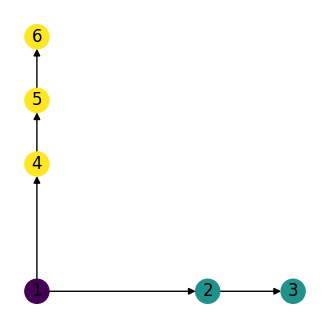

In [1674]:
graph_vis(swc_jaxley, node_color=[d["id"] for n, d in swc_jaxley.nodes(data=True)], with_labels=True)

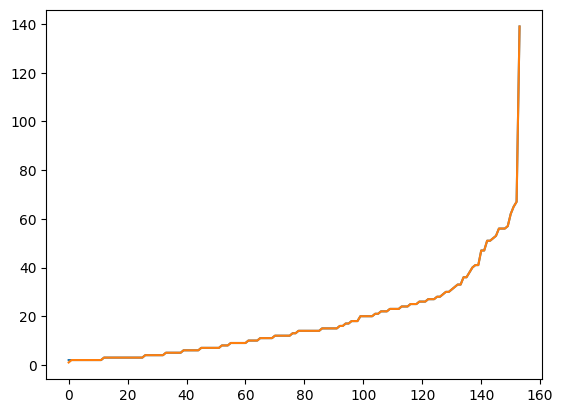

In [1728]:
fname = "tests/swc_files/morph_3_types_single_point_soma.swc"
fname = "tests/swc_files/morph_ca1_n120_single_point_soma.swc"
swc_jaxley = graph_io_new.swc_to_nx(fname)

branches_v1 = [b[:, :2].astype(int) for b in graph_io_old._trace_branches(graph_io_old.to_swc_graph(fname))[1]]
# Convert edges per branch [(n1, n2), (n2, n3), ...] to node list [n1, n2, n3, ...] using a comprehension
branches_v1 = [
    [edge_list[0, 0].item()] + edge_list[:, 1].tolist() if len(edge_list) > 0 else []
    for edge_list in branches_v1
]
branches_v2 = graph_io_new.list_branches(swc_jaxley)
branches_v3 = list_branches(swc_jaxley.to_undirected())

# missmatch from id based branch splitting and in which order / direction 
# the branches are traversed. v1 and Neuron traverse in increasing order of node id,
# setting source=1 in v2 ensures that the branches are traversed in the same order as v1 for some reason
plt.plot(sorted([len(b) for b in branches_v1]))
# plt.plot(sorted([len(b) for b in branches_v2]))
plt.plot(sorted([len(b) for b in branches_v3]))

In [17]:
from jaxley.utils.cell_utils import compute_cone_props

In [361]:
#########################################################################################
################################### Helper functions ####################################
#########################################################################################

def pandas_to_nx(
    node_attrs: pd.DataFrame, edge_attrs: pd.DataFrame, global_attrs: pd.Series
) -> nx.Graph:
    """Convert node_attrs, edge_attrs and global_attrs from pandas datatypes to a NetworkX DiGraph.

    Args:
        node_attrs: DataFrame containing node attributes
        edge_attrs: DataFrame containing edge attributes
        global_attrs: Series containing global graph attributes

    Returns:
        A directed graph with nodes, edges and global attributes from the input data.
    """
    G = nx.from_pandas_edgelist(
        edge_attrs.reset_index(),
        source="level_0",
        target="level_1",
        edge_attr=True if edge_attrs.columns.size > 0 else None,
        create_using=nx.Graph(),
    )
    G.add_nodes_from((n, d) for n, d in node_attrs.to_dict(orient="index").items())
    G.graph.update(global_attrs.to_dict())
    return G


def nx_to_pandas(
    G: nx.Graph, sort_index: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """Convert a NetworkX DiGraph to pandas datatypes.

    Args:
        G: Input directed graph
        sort_index: Whether to sort the index of the DataFrames.

    Returns:
        Tuple containing:
        - DataFrame of node attributes
        - DataFrame of edge attributes
        - Series of global graph attributes
    """
    edge_df = nx.to_pandas_edgelist(G).set_index(["source", "target"])
    edge_df.index.names = [None, None]
    node_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")
    node_df = node_df.sort_index() if sort_index else node_df
    edge_df = edge_df.sort_index() if sort_index else edge_df

    return node_df, edge_df, pd.Series(G.graph)


########################################################################################
################################### BUILD SWC GRAPH ####################################
########################################################################################


def read_swc(fname: str, num_lines: Optional[int] = None) -> np.ndarray:
    """Read a SWC morphology file into a numpy array.

    Args:
        fname: Path to the SWC file
        num_lines: Number of lines to read from the file. If None, all lines are read.

    Returns:
        A numpy array of the SWC file.
    """
    return np.loadtxt(fname)[:num_lines]

# def nx_to_swc(G: nx.Graph) -> np.ndarray:
#     """Convert a NetworkX Graph to a numpy array.

#     Args:
#         G: NetworkX Graph

#     Returns:
#         A numpy array of the SWC file.
#     """
#     return 

def swc_to_nx(
    swc: np.ndarray,
    relevant_ids: Optional[List[int]] = None,
) -> nx.Graph:
    """Read a SWC morphology file into a NetworkX DiGraph.

    The graph is read such that each entry in the swc file becomes a graph node
    with the column attributes (id, x, y, z, r). Then each node is connected to its
    designated parent via an edge.

    Args:
        swc: numpy array of the SWC file.
        relevant_ids: List of ids to include in the graph. Defaults to [1, 2, 3, 4].
            All other ids are set to 0.

    Returns:
        A networkx DiGraph of the traced morphology in the swc file. It has attributes:
        nodes: {'id': 1, 'x': 0.0, 'y': 0.0, 'z': 0.0, 'r': 1.0}
        edges: {}

    Example usage
    ^^^^^^^^^^^^^

    ::

        from jaxley.io.graph swc_to_nx
        swc_graph = swc_to_nx("path_to_swc.swc")
    """
    relevant_ids = relevant_ids or [1, 2, 3, 4]

    graph = nx.Graph()
    fmt_id = lambda id: int(id) if id in relevant_ids else 0
    for i, id, x, y, z, r, p in swc.tolist():  # tolist: np.float64 -> float
        graph.add_node(int(i), **{"id": fmt_id(id), "x": x, "y": y, "z": z, "r": r})
        if p != -1:
            graph.add_edge(int(p), int(i))
    return graph


def split_branches(
    branches: list[list[int]], split_edges: list[tuple[int, int]]
) -> list[list[int]]:
    """Split branches at the given edges.

    Args:
        branches: List of branches, each represented as list of nodes.
        split_edges: List of edges between nodes where tracing is discontinous.

    Returns:
        An updated list of branches.
    """
    for n1, n2 in split_edges:
        for i, branch in enumerate(branches):
            if n1 in branch and n2 in branch:
                if branch.index(n1) > branch.index(n2):
                    n1, n2 = n2, n1
                start = branch.index(n1) + 1
                end = branch.index(n2) - 1
                branches[i : i + 1] = [branch[:start], branch[end:]]
                break
    return branches

def split_long_branches(
    G: nx.Graph, branches: list[list[int]], max_len: float = 242.0
) -> list[list[int]]:
    """Splits too long branches at equidistant points.

    If branch >= 1*max_len, then we split it down the middle. If branch >= 2*max_len,
    then we split it into 3 parts. And so on. This ensures that sub-branches have similar
    length & length <= max_len.

    Args:
        G: NetworkX graph tracing of swc file.
        branches: List of branches, each represented as list of nodes.
        max_len: Maximum length any branch cannot exceed.

    Returns:
        Branches such that no branch exceeds max_len and such that the resulting sub-branches
        are of similar length.
    """
    xyz = nx_to_pandas(G)[0][["x","y", "z"]]
    path_len = lambda df: df.diff().apply(np.linalg.norm, axis=1).fillna(0).cumsum()

    splits = []
    for branch in branches:
        lens = path_len(xyz.loc[branch])
        num_splits = int(lens.max() // max_len) + 1

        for seg in np.linspace(0, lens.max(), num_splits+1)[1:-1]:
            is_less = lens <= seg
            splits.append((lens.index[is_less][-1], lens.index[~is_less][0]))
    return split_branches(branches, splits)

def list_branches(
    G: nx.Graph,
    source: Optional[int] = None,
    max_len: Optional[float] = None,
    ignore_swc_tracing_interruptions: bool = True,
    return_branchpoints: bool = False,
) -> list[list[int]]:
    """Get all uninterrupted paths in the traced morphology (i.e. branches).

    The graph is traversed depth-first starting from the first found leaf node.
    Nodes are considered to be part of a branch if they have only one parent and one
    child, which are both of the same type (i.e. have the same `id`). Nodes which are
    branchpoints or leafs are considered start / end points of a branch. A branchpoint
    can start multiple branches.

    Some swc files contain artefacts, where tracing of the same neurite was done
    in disconnected pieces. NEURON swc reader introduce a break in the trace at these
    points, since they parse the file in order. This leads to split branches, which
    should be one. This function identifies these points in the graph.

    Example swc file:
    # branch 1
    1 1 0.0 0.0 0.0 1.0 -1
    2 1 1.0 0.0 0.0 1.0 1
    3 1 2.0 0.0 0.0 1.0 2
    # branch 2
    4 2 3.0 1.0 0.0 1.0 3
    5 2 4.0 2.0 0.0 1.0 4
    # branch 3
    6 3 3.0 -1.0 0.0 1.0 3
    7 3 4.0 -2.0 0.0 1.0 6
    8 3 5.0 -3.0 0.0 1.0 7
    # ammend branch 2
    9 4 5.0 3.0 0.0 1.0 5

    Args:
        G: NetworkX graph tracing of swc file.
        source: The node from which to start tracing the graph. If None, the first leaf
            node is used.
        max_len: The maximum length of a branch. If None, there is no limit.
        ignore_swc_tracing_interruptions: Whether to ignore discontinuities in the swc
            tracing order. If False, this will result in split branches at these points.
        return_branchpoints: Whether to return the branchpoints and edges between them
            seperately.

    Returns:
        A list of linear paths in the graph. Each path is represented as list of nodes.
    """
    id_of = lambda n: G.nodes[n]["id"] if "id" in G.nodes[n] else 0

    def is_id_branchpoint(n: int) -> bool:
        """Check if degree-2 node n is a branchpoint based on ID.
        
        Trace dir matters here! For segment [0,1,2,3] with node IDs: [1,1,2,2]
        -> [[1,1], [1,2,2]] => node 1 is taken as branchpoint
        <- [[2,2], [2,1,1]] => node 2 is taken as branchpoint
        """
        if G.degree(n) == 2:
            i, j = G.neighbors(n)
            return not id_of(n) == id_of(j)
        return False

    soma_nodes = [n for n, d in G.nodes.items() if d["id"] == 1]
    leaf = next(n for n in G.nodes() if G.degree(n) == 1)
    source = leaf if source is None else source
    
    swc_interupts = []
    branches = [soma_nodes] if len(soma_nodes) == 1 else [] # a single soma is its own branch
    for (n1, n2) in nx.dfs_edges(G, source=source):
        if G.degree(n1) != 2 or n1 == source or is_id_branchpoint(n1):
            branches.append([n1, n2])
        else:
            branches[-1].append(n2)
            # non-continous node indices which are not branchpoints, i.e. edges where node 
            # indices are > 1 apart, signal that a branch was interrupted during tracing
            if np.abs(n2 - n1) != 1:
                swc_interupts.append((n1, n2))

    # split branches (if tracing was interrupted or max_len is reached)
    if not ignore_swc_tracing_interruptions:
        branches = split_branches(branches, swc_interupts)

    # max_len splitting only after accounting for interrupted branches
    if max_len is not None:
        branches = split_long_branches(G, branches, max_len)

    branch_tips = sum([[b[0], b[-1]] for b in branches], [])
    branchpoints_tips = sorted(set(branch_tips))
    
    return (branches, branchpoints_tips) if return_branchpoints else branches


def _add_missing_swc_attrs(G) -> nx.DiGraph:
    """Add missing swc attributes to a SWC graph.

    Allows to specify morphology from just edges.

    Args:
        G: The SWC graph to add missing attributes to.

    Returns:
        The SWC graph with missing attributes set to their defaults.
    """
    defaults = {"id": 0, "r": 1}

    available_keys = G.nodes[next(iter(G.nodes()))].keys()
    xyz = graph_io_new.compute_xyz(G) if "x" not in available_keys else {}
    for n, (x, y, z) in xyz.items():
        # xyz is needed to compute compartment lengths
        G.nodes[n]["x"] = x
        G.nodes[n]["y"] = y
        G.nodes[n]["z"] = z

    for key in set(defaults.keys()).difference(available_keys):
        nx.set_node_attributes(G, defaults[key], key)
    return G


def compartmentalize_branch(
    branch_nodes: pd.DataFrame,
    ncomp: int,
    ignore_branchpoints: Tuple[bool, bool] = (False, False),
) -> pd.DataFrame:
    """Interpolate or integrate node attributes along branch.

    Takes a dataframe with nodes (index) and node attributes (columns) and returns a
    dataframe of compartments and compartment attributes. Compartments are spaced at
    equidistant points along the branch. Node attributes, like radius are linearly
    interpolated along its length.

    Example: 4 compartments | edges = - | nodes = o | comp_nodes = x
    o-----------o----------o---o---o---o--------o
    o-------x---o----x-----o--xo---o---ox-------o

    Args:
        branch_nodes: DataFrame of node attributes for nodes in a branch.
            needs to include morph attributes `id`, `x`, `y`, `z`, `r`.
        ncomp: Number of compartments per branch.
        ignore_branchpoints: Whether to consider the branchpoint part of the neurite or
        not. This is for example relevant if the branch extends
        from a single point soma or somatic branchpoint. In these cases, the somatic SWC
        node is _not_ considered to be part of the dendrite.
        interp_attrs: Additional attributes to interpolate along the branch.
            Cannot include `x`, `y`, `z`, `r`.
        const_attrs: Additional attributes to set to that of the first branch node.
            Cannot include `id`.

    Returns:
        DataFrame of compartments and compartment attributes.
    """
    # TODO: This function should be reusable for `set_ncomp()`
    for attr in set(["x", "y", "z", "r", "id"]):
        assert attr in branch_nodes.columns, f"Branch nodes must contain '{attr}'."

    # all nodes in a branch must have the same id. since branchpoints can have a
    # different id (attached at the ends), the node after the branchpoint det. branch id
    branch_id = branch_nodes["id"].iloc[1 if len(branch_nodes) > 1 else 0]
    not_branch_id = (branch_nodes["id"] != branch_id).values
    branch_nodes.loc[not_branch_id, "id"] = branch_id

    # if branchpoint has a different id, its radius is assumed to be equal to that
    # of the neighbouring node.
    if not_branch_id[0] and len(branch_nodes) > 2:
        branch_nodes.loc[branch_nodes.index[0], "r"] = branch_nodes["r"].values[1]
    if not_branch_id[-1] and len(branch_nodes) > 2:
        branch_nodes.loc[branch_nodes.index[-1], "r"] = branch_nodes["r"].values[-2]

    inds = branch_nodes.index
    inds = inds[1:] if ignore_branchpoints[0] else inds
    inds = inds[:-1] if ignore_branchpoints[1] else inds
    branch_nodes = branch_nodes.loc[inds]

    # set edge lengths to 0 for branchpoints of different id if ignore_branchpoints
    edge_lens = (branch_nodes[["x", "y", "z"]].diff(axis=0) ** 2).sum(axis=1) ** 0.5
    branch_nodes["l"] = edge_lens.fillna(0).cumsum()  # path length

    # handle single point branches / somata
    node_inds_in_branch = branch_nodes.index.tolist()
    if len(node_inds_in_branch) == 1:
        # duplicate node to compartmentalize it along its "length", i.e. l = 2*r
        branch_nodes = branch_nodes.loc[node_inds_in_branch * 2]
        # Setting l = 2*r ensures A_cylinder = 2*pi*r*l = 4*pi*r^2 = A_sphere.
        branch_nodes["l"] = np.array([0, 2 * branch_nodes["r"].iloc[0]])

    ls = branch_nodes["l"].values
    rs = branch_nodes["r"].values
    branch_len = max(ls)

    if branch_len < 1e-8:
        warn(
            "Found a branch with length 0. To avoid NaN while integrating the "
            "ODE, we capped this length to 0.1 um. The underlying cause for the "
            "branch with length 0 is likely a strange SWC file. The "
            "most common reason for this is that the SWC contains a soma "
            "traced by a single point, and a dendrite that connects to the soma "
            "has no further child nodes."
        )
    comp_len = branch_len / ncomp

    # Create node indices and attributes for branch-tips/branchpoints and comps
    # is_comp, comp_len, comp_id, x, y, z, r, area, volume, res_in, res_out
    cone_prop_cols = ["r", "area", "volume", "resistive_load_in", "resistive_load_out"]
    cols = ["l", "x", "y", "z"] + cone_prop_cols
    comp_attrs = pd.DataFrame(np.full((ncomp + 2, len(cols)), np.nan), columns=cols)

    comp_attrs["id"] = np.array([0, *[branch_id] * ncomp, 0], dtype=int)
    is_comp = np.array([False, *[True] * ncomp, False], dtype=bool)
    comp_attrs.loc[is_comp, "l"] = comp_len

    tip_cols = ["id", "x", "y", "z", "r"]
    comp_attrs.loc[~is_comp, tip_cols] = branch_nodes[tip_cols].iloc[[0, -1]].values

    # Interpolate attrs along branch
    comp_centers = np.linspace(comp_len / 2, branch_len - comp_len / 2, ncomp)
    comp_centers = np.array([0, *comp_centers, branch_len])
    comp_ends = np.linspace(0, branch_len, ncomp + 1)
    comp_tips = np.stack([comp_ends[:-1], comp_ends[1:]], axis=1)

    interp1d = lambda x: np.interp(comp_centers, ls, x)
    interp_arr = branch_nodes[["x", "y", "z"]].values
    comp_attrs[["x", "y", "z"]] = np.apply_along_axis(
        interp1d, axis=0, arr=interp_arr
    )

    # compute radius, area, volume, res_in, res_out
    cone_props = np.array([compute_cone_props(ls, rs, x1, x2) for x1, x2 in comp_tips])
    comp_attrs.loc[is_comp, cone_prop_cols] = cone_props

    return comp_attrs


def propose_new_inds(existing_inds: List[int], num_additional_inds: int) -> List[int]:
    """Propose new set of indices that does not overlap with existing indices.

    Args:
        existing_inds: Existing indices.
        num_additional_inds: Number of additional indices to propose.

    Returns:
        List of proposed indices.
    """
    existing_inds = set(existing_inds)
    all_new_inds = set(range(num_additional_inds + len(existing_inds)))
    proposed_inds = list(all_new_inds - existing_inds)  # avoid node inds overlap
    return proposed_inds


def build_compartment_graph(
    swc_graph: nx.DiGraph,
    ncomp: int = 1,
    root: Optional[int] = None,  # TODO: change to source ?
    min_radius: Optional[float] = None,
    max_len: Optional[float] = None,
    ignore_swc_tracing_interruptions: bool = True,
) -> nx.DiGraph:
    """Return a networkX graph that indicates the compartment structure.

    Build a new graph made up of compartments in every branch. These compartments are
    spaced at equidistant points along the branch. Node attributes, like radius are
    linearly interpolated along its length.

    Example: 4 compartments | edges = - | nodes = o | comp_nodes = x
    o-----------o----------o---o---o---o--------o
    o-------x---o----x-----o--xo---o---ox-------o

    This function returns a nx.DiGraph. The graph is directed only because every
    compartment tracks the xyzr coordinates of the associated SWC file. These xyzr
    coordinates are ordered by the order of the traversal of the swc_graph. In later
    methods (e.g. build_solve_graph), we traverse the `comp_graph` and mostly ignore
    the directionality of the edges, but we only use the directionality to reverse the
    xyzr coordinates if necessary.

    Args:
        swc_graph: Graph generated by `swc_to_nx()`.
        ncomp: How many compartments per branch to insert.
        root: The root branch from which to start tracing the nodes. This defines the
            branch indices.
        min_radius: Minimal radius for each compartment.
        max_len: Maximal length for each branch. Longer branches are split into
            separate branches.
        ignore_swc_tracing_interruptions: If `False`, it this function automatically
            starts a new branch when a section is traced with interruptions.

    Returns:
        Graph of the compartmentalized morphology.

    Example usage
    ^^^^^^^^^^^^^

    ::

        from jaxley.io.graph swc_to_nx
        swc_graph = swc_to_nx("path_to_swc.swc")
        comp_graph = build_compartment_graph(swc_graph, ncomp=1)
    """
    G = _add_missing_swc_attrs(swc_graph)

    branches = list_branches(
        G,
        source=root,
        ignore_swc_tracing_interruptions=ignore_swc_tracing_interruptions,
        max_len=max_len,
    )

    nodes_df = nx_to_pandas(G)[0]

    # threshold radius
    if min_radius is None:
        msg = "Radius 0.0 in SWC file. Set `read_swc(..., min_radius=...)`."
        assert (nodes_df["r"] > 0.0).all(), msg
    else:
        nodes_df["r"] = np.maximum(nodes_df["r"], min_radius)

    # identify somatic branchpoints. A somatic branchpoint is a branchpoint at which at
    # least two connecting branches are somatic. In that case (and in the case of a
    # single-point soma), non-somatic branches are assumed to start from their first
    # traced point, not from the soma.
    soma_nodes = [n for n in G.nodes if G.nodes[n]["id"] == 1]
    single_soma = len(soma_nodes) == 1
    soma_branchpoints = [n for n in soma_nodes if G.degree(n) > 2 or single_soma]
    somatic_nns = lambda n: [n for n in G.neighbors(n) if G.nodes[n]["id"] == 1]
    somatic_branchpoints = [n for n in soma_branchpoints if len(somatic_nns(n)) >= 2 or single_soma]
    
    # create new set of indices which arent already used as node indices to label comps
    existing_inds = nodes_df.index
    num_additional_inds = len(branches) * ncomp
    proposed_node_inds = propose_new_inds(existing_inds, num_additional_inds)

    # collect comps and comp_edges
    comps, comp_edges, xyzr = [], [], []
    for branch_idx, branch in enumerate(branches):
        branch_nodes = nodes_df.loc[branch]

        # Compute the compartmentalization of the branch.
        not_soma = branch_nodes["id"].iloc[1 if len(branch_nodes) > 1 else 0] != 1
        ignore_somatic_bpt = [not_soma and branch[0] in somatic_branchpoints]
        ignore_somatic_bpt += [not_soma and branch[-1] in somatic_branchpoints]
        comp_attrs = compartmentalize_branch(branch_nodes, ncomp, ignore_somatic_bpt)

        # Attach branchpoint and tip nodes to the branch.
        # Since branchpoints / tips have the same node_index as in the original graph
        # there is no need to keep track of branch connectivity.
        comp_inds = [proposed_node_inds.pop(0) for _ in range(ncomp)]
        comp_attrs["node"] = np.array([branch[0], *comp_inds, branch[-1]], dtype=int)
        comp_attrs["branch_index"] = [pd.NA, *[branch_idx] * ncomp, pd.NA]

        # single soma branches lead to self looping edges, since branch[0] == branch[-1]
        # we therefore remove one tip node / branchpoint node, i.e. [0,s,0] -> [s,0]
        comp_attrs = comp_attrs.iloc[1:] if branch[0] == branch[-1] else comp_attrs

        # Store edges, nodes, and xyzr in branch-wise manner
        node_inds = comp_attrs["node"]
        comp_edges += [np.stack([node_inds.iloc[:-1], node_inds.iloc[1:]]).T.tolist()]
        comps.append(comp_attrs)

        # store xyzr for each node in branch
        xyzr.append(branch_nodes[["x", "y", "z", "r"]].values)

    comp_df = pd.concat(comps)

    # drop duplicated branchpoint nodes and fill with original attrs of branchpoint node
    comp_df = comp_df.drop_duplicates(subset=["node"])
    comp_df = comp_df.set_index("node")
    xyzr_cols = ["x", "y", "z", "r"]
    is_comp = comp_df["branch_index"].notna()
    at_branchpoints = comp_df.loc[~is_comp].index
    comp_df.loc[at_branchpoints, xyzr_cols] = nodes_df.loc[at_branchpoints, xyzr_cols]

    # create comp edges
    comp_edges = sum(comp_edges, [])
    comp_edges_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(comp_edges))
    comp_edges_df["synapse"] = False  # edges between compartments that are synapses
    comp_edges_df["comp_edge"] = True  # edges between connected compartments

    global_attrs = pd.Series({"xyzr": xyzr})
    G = pandas_to_nx(comp_df, comp_edges_df, global_attrs)

    # relabel nodes to [0, 1, ..., ncomp-1] -> [ncomp, ncomp+1, ..., nbranchpoints-1]
    # this way the branchpoints can be appended to the end of nodes
    branch_inds = nx.get_node_attributes(G, "branch_index")
    is_comp = [n for n, c in branch_inds.items() if not pd.isna(c)]
    not_comp = [n for n, c in branch_inds.items() if pd.isna(c)]
    comp_labels = {n: i for i, n in enumerate(is_comp)}
    branchpoint_labels = {n: i + len(comp_labels) for i, n in enumerate(not_comp)}
    G = nx.relabel_nodes(G, {**comp_labels, **branchpoint_labels})
    return G

def _extract_branchpoints(G: nx.Graph) -> nx.Graph:
    """Move branchpoints to graph.graph and contract branchpoint nodes with their neighbour.

    Removes all branchpoint and tip nodes by contracting it into the neighbour with the
    lowest node_index. All branchpoints and tips are moved to the global graph attribute
    `branchpoints_and_tips`.

    Choosing the lowest node is somewhat arbitrary and can result in different graphs.
    See example below:
    [[1] = branchpoint, (1) = compartment]

                Example 1             |            Example 2
    ----------------------------------|----------------------------------
     (1) --> [2] --> (3)  (1) --> (3) | (3) <-- [2] <-- (1)  (2) <-- (1)
              |            |          |          |                    |
              v            v          |          v                    v
             (4)          (4)         |         (4)                  (4)

    Args:
        G: The graph with branchpoints and tips.

    Returns:
        The graph without branchpoints and tips.
    """
    branchpoints_tips = {
        n: d for n, d in G.nodes(data=True) if pd.isna(d["branch_index"])
    }

    updated_G = G.copy()
    for n in list(branchpoints_tips.keys()):
        branchpoint_edges = sorted(G.edges(n))
        branchpoints_tips[n]["edges"] = branchpoint_edges
        rm_edge = branchpoint_edges[0]
        rm_edge = rm_edge[::-1] if n == rm_edge[0] else rm_edge
        updated_G = nx.contracted_nodes(
            updated_G, *rm_edge, self_loops=False, copy=False
        )
        del updated_G.nodes[rm_edge[0]]["contraction"]

    updated_G.graph["branchpoints_and_tips"] = pd.DataFrame(branchpoints_tips).T
    return updated_G


def _insert_branchpoints(G: nx.Graph) -> nx.Graph:
    """Move branchpoints back from graph.graph into graph.nodes.

    Inserts branchpoint and tip nodes back into the graph and restores reconnects them
    to their respective neighbours. Removes `branchpoints_and_tips` attribute from graph.

    Examples:
    [[1] = branchpoint, (1) = compartment]

                Example 1             |            Example 2
    ----------------------------------|----------------------------------
     (1) --> (3)  (1) --> [2] --> (3) | (1) <-- (2)  (1) <-- [2] <-- (3)
      |                    |          |          |            |
      v                    v          |          v            v
     (4)                  (4)         |         (4)          (4)

    Args:
        G: The graph without branchpoints and tips.

    Returns:
        The graph with branchpoints and tips.
    """
    branchpoint_edges = G.graph["branchpoints_and_tips"].pop("edges")
    branchpoints_tips = G.graph["branchpoints_and_tips"].T.to_dict()
    del G.graph["branchpoints_and_tips"]

    updated_G = G.copy()
    edge_attrs = {"comp_edge": True, "synapse": False}

    for node, edges in branchpoint_edges.items():
        # Find the sink node (the one that absorbed the branchpoint)
        # assumes 1st edge was contracted
        sink = edges[0][0] if edges[0][1] == node else edges[0][1]

        # Create list of edges to remove by replacing node with sink
        edges_to_remove = [
            (sink if u == node else u, sink if v == node else v) for u, v in edges
        ]

        # Remove the contracted edges
        updated_G.remove_edges_from(edges_to_remove)

        # Restore branchpoint and its original edges
        updated_G.add_node(node, **branchpoints_tips[node])
        updated_G.add_edges_from(edges, **edge_attrs)

    return updated_G

In [407]:
def comp_to_branch_graph(G, relabel_nodes=True):
    node_df = graph_io_new.nx_to_pandas(G)[0]
    branch_graph = G.copy()
    
    for _, cell_df in node_df.groupby("cell_index"):
        nodes_in_branch = cell_df.groupby("branch_index").apply(lambda x: x.index, include_groups=False)
        for _, branch_nodes in nodes_in_branch.items():
            root, *branch_nodes = branch_nodes
            for n in branch_nodes:
                branch_graph = nx.contracted_nodes(branch_graph, root, n, self_loops=False, copy=False)
    
    if relabel_nodes:
        branch_labels = nx.get_node_attributes(branch_graph, "branch_index")
        branch_graph = nx.relabel_nodes(branch_graph, branch_labels)
    return branch_graph

<Axes: >

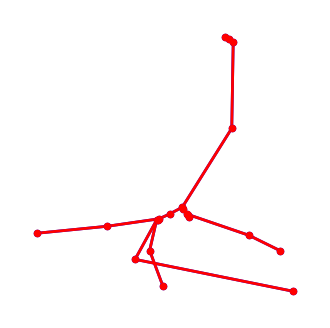

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
graph_vis(re_graph, ax=ax, node_size=20, node_color="b", arrows=False, edge_color="b", width=2.0)
graph_vis(comp_graph, ax=ax, node_size=20, node_color="r", arrows=False, edge_color="r", width=2.0)

In [ ]:
## on da46adbb
# Failures expected, since morph is slightly different from previous versions, but more accurate in theory
# FAILED tests/jaxley_identical/test_swc.py::test_swc_cell[morph_ca1_n120.swc-jaxley.dhs.cpu] - AssertionError: Error is 5.775397720342347 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.cpu-morph_ca1_n120] - AssertionError: Error is 5.775397720342347 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jax.sparse-morph_ca1_n120] - AssertionError: Error is 5.775397720344767 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.cpu-morph_ca1_n120_250] - AssertionError: Error is 6.045891080393293 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.gpu-morph_ca1_n120_250] - AssertionError: Error is 6.045891080393783 > 1e-08

# Open issues:
# FAILED tests/jaxley_identical/test_swc.py::test_swc_cell[morph_ca1_n120_single_point_soma.swc-jaxley.dhs.cpu] - KeyError: '[1] not in index'
# FAILED tests/jaxley_vs_neuron/test_swc.py::test_swc_voltages[morph_ca1_n120_single_point_soma.swc] - KeyError: '[1] not in index'
# FAILED tests/jaxley_vs_neuron/test_swc.py::test_swc_voltages[morph_allen_485574832.swc] - KeyError: '[1] not in index'
# FAILED tests/test_graph.py::test_from_graph_vs_NEURON[morph_ca1_n120_single_point_soma.swc] - KeyError: '[1] not in index'

In [17]:
import jaxley as jx
from jaxley.channels import HH
import matplotlib.pyplot as plt

comp = jx.Compartment()
comp.insert(HH())
comp.record()
comp.init_states()

v = jx.integrate(comp, t_max=10.0)

Added 1 recordings. See `.recordings` for details.


In [ ]:
jx.Cell()

Cell with 0 different channels. Use `.nodes` for details.

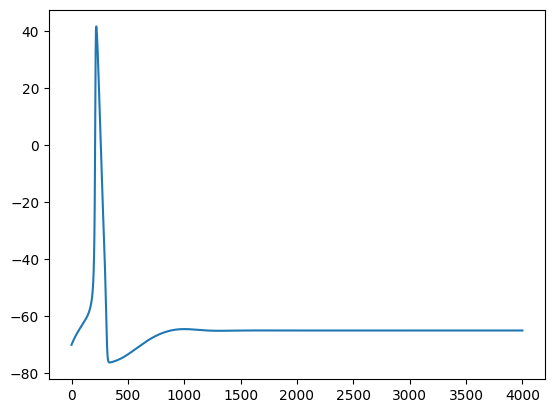

In [16]:
plt.plot(v.T)

(-15.0, 5.0)

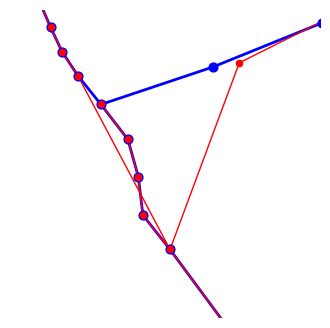

In [2101]:
#### NEURON SWC READER ADDS EDGES THAT ARE NOT IN THE SWC FILE !?!?!?!?!?####

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"
neuron_swc = swc_to_nx_with_neuron(fname, merge_branchpoints=True)

# neuron_swc.remove_edge(8, 601)
# neuron_swc.add_edge(601, 0)
# neuron_swc.remove_edge(8, 0)

# jaxley_swc = graph_io_new.swc_to_nx(fname)

# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# graph_vis(jaxley_swc, ax=ax, node_size=20, node_color="b", arrows=False, edge_color="b", width=2.0)
# graph_vis(neuron_swc, ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=1.0, with_labels=True)
# soma_nodes = [n for n, d in neuron_swc.nodes(data=True) if d["id"] == 1]
# # graph_vis(neuron_swc.subgraph(soma_nodes), ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=1.0)
# # graph_vis(neuron_swc.subgraph(soma_nodes), ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=2, show_radii=True)

# ax.set_xlim(-1, 5)
# ax.set_ylim(-13, 2)

ncomp = 5
solve_graph_neuron = build_solve_graph_with_neuron(fname, ncomp=ncomp, drop_neuron_specific_attrs=True)

comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=ncomp, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)
solve_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
graph_vis(solve_graph_jaxley, ax=ax, node_size=40, node_color="b", arrows=False, edge_color="b", width=2.0)
graph_vis(solve_graph_neuron, ax=ax, node_size=20, node_color="r", arrows=False, edge_color="r", width=1.0)

ax.set_xlim(-3, 9)
ax.set_ylim(-15, 5)

In [1433]:
##### ALL MORPH NODE ATTRIBUTES MATCH BETWEEN NEURON AND JAXLEY GRAPHS #####

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

ncomps = 1
neuron_swc_reader(fname, ncomps)
neuron_swc = neuron_swc_graph()
branches_neuron = neuron_list_branches(neuron_swc)
neuron_swc = contract_similar_nodes(neuron_swc)
solve_graph_neuron = neuron_solve_graph(ncomp=ncomps)

jaxley_swc = graph_io_new.swc_to_nx(fname)
branches_jaxley = graph_io_new.list_branches(jaxley_swc, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new.build_compartment_graph(jaxley_swc, ncomp=ncomps, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)
solve_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)

# match swc against neuron
matched_jaxley_swc = match_nodes(jaxley_swc.copy(), neuron_swc)
for key in ["r", "l", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(neuron_swc, matched_jaxley_swc, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all), f"|{key}-{key}'| > {1e-5} for some nodes")

# # match branches
# assert len(branches_jaxley) == len(branches_neuron), "Number of branches is not the same"
# branches_jaxley = match_branches(jaxley_swc, neuron_swc, branches_jaxley, branches_neuron)

# match comp graph against neuron
comp_graph_jaxley = match_nodes(comp_graph_jaxley, solve_graph_neuron, match_on="xyz", tol=1e-3, assert_unique=False)
shared_nodes = set(comp_graph_jaxley.nodes()) & set(solve_graph_neuron.nodes())
for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(comp_graph_jaxley, solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

# match solve graph against neuron
solve_graph_jaxley = match_nodes(solve_graph_jaxley, solve_graph_neuron, match_on="xyz", tol=1e-3)
for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(solve_graph_jaxley, solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

# match modules

(-13.0, 2.0)

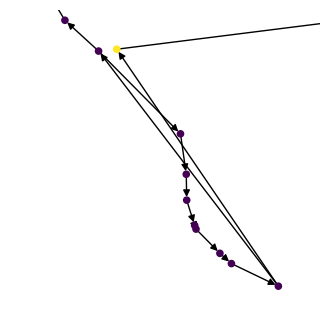

In [2102]:
neuron_swc_reader(fname)
swc_graph_neuron = neuron_swc_graph(merge_branchpoints=True)
# these need to be removed for some reaon!?
# swc_graph_neuron.remove_edge(8, 601)
# swc_graph_neuron.remove_edge(8, 0)
# swc_graph_neuron.add_edge(601, 0)

subg = swc_graph_neuron.subgraph(list(range(13)) + list(range(601, 604)))
node_colors = [subg.nodes[n].get('id', 0) for n in subg.nodes()]
graph_vis(subg, node_size=20, node_color=node_colors)
plt.xlim(-2, 5)
plt.ylim(-13, 2)

In [2173]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

h.secondorder = 0

for sec in h.allsec():
    h.delete_section(sec=sec)

cell = h.Import3d_SWC_read()
cell.input(fname)
i3d = h.Import3d_GUI(cell, False)
i3d.instantiate(None)

for sec in h.allsec():
    sec.nseg = 1
neuron_branch_lens = np.sort([sec.L for sec in h.allsec()])

# pre-processing
swc_graph = graph_io_new.swc_to_nx(fname)
comp_graph = graph_io_new.build_compartment_graph(
    swc_graph, ncomp=1, ignore_swc_tracing_interruptions=False
)

df = pd.Series(nx.get_node_attributes(comp_graph, "l"))
nx_branch_lens = df[df.notna()].sort_values().values


errors = np.abs(neuron_branch_lens - nx_branch_lens)

# plt.plot(neuron_branch_lens)
# plt.plot(nx_branch_lens)
assert sum(errors > 1e-3) == 0

AssertionError: 

In [2106]:
from neuron import h

import jaxley as jx
from jaxley.channels import HH

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

i_delay = 5.0
i_dur = 20.0
i_amp = 1.0
t_max = 30.0
dt = 0.025

stim_loc = 0.51
loc = 0.51

ncomp_per_branch = 3

##################### NEURON ##################
h.secondorder = 0

for sec in h.allsec():
    h.delete_section(sec=sec)

cell = h.Import3d_SWC_read()
cell.input(fname)
i3d = h.Import3d_GUI(cell, False)
i3d.instantiate(None)

for sec in h.allsec():
    sec.nseg = ncomp_per_branch

pathlengths_neuron = np.asarray([sec.L for sec in h.allsec()])

####################### jaxley ##################
# ## bachend = "neuron-swc"
# neuron_swc_reader(fname)
# swc_graph_neuron = neuron_swc_graph(merge_branchpoints=True)
# # these need to be removed for some reaon!?
# swc_graph_neuron.remove_edge(8, 601)
# swc_graph_neuron.remove_edge(8, 0)
# swc_graph_neuron.add_edge(601, 0)
# for n in swc_graph_neuron.nodes():
#     del swc_graph_neuron.nodes[n]["sec_name"]
# comp_graph_neuron = graph_io_new.build_compartment_graph(swc_graph_neuron, ncomp=ncomp_per_branch, max_len=2_000.0)
# cell = graph_io_new.from_graph(comp_graph_neuron)

# ## backend = "neuron-full"
# neuron_swc_reader(fname)
# solve_graph_neuron = neuron_solve_graph(ncomp=ncomp_per_branch)
# cell = graph_io_new._build_module(solve_graph_neuron)

# ## backend = "graph-new"
# jaxley_swc_new = graph_io_new.swc_to_nx(fname)
# comp_graph_new = graph_io_new.build_compartment_graph(jaxley_swc_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_new)

# ## backend = "graph-old"
jaxley_swc_old = graph_io_old.to_swc_graph(fname)
comp_graph_old = graph_io_old.build_compartment_graph(jaxley_swc_old, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
cell = graph_io_old.from_graph(comp_graph_old)

pathlengths = []
for branch in cell.branches:
    pathlengths.append(branch.nodes["length"].sum())
pathlengths_jaxley = np.asarray(pathlengths)

jaxley_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
jaxley_inds = [ind for ind in jaxley_inds if ind < len(pathlengths_jaxley)]

neuron_inds = []
for jaxley_ind in jaxley_inds:
    for i, p in enumerate(pathlengths_jaxley):
        if i == jaxley_ind:
            closest_match = np.argmin(np.abs(pathlengths_neuron - p))
            neuron_inds.append(closest_match)

cell.insert(HH())
cell.set("axial_resistivity", 100.0)
cell.set("v", -62.0)
cell.set("HH_m", 0.074901)
cell.set("HH_h", 0.4889)
cell.set("HH_n", 0.3644787)

jaxley_stim = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.soma.branch(0).loc(stim_loc).stimulate(jaxley_stim)
for i in jaxley_inds:
    cell.branch(i).loc(loc).record(verbose=False)

voltages_jaxley = jx.integrate(cell, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

################### NEURON #################
stim = h.IClamp(h.soma[0](stim_loc))
stim.delay = i_delay
stim.dur = i_dur
stim.amp = i_amp

counter = 0
voltage_recs = {}

for r in neuron_inds:
    for i, sec in enumerate(h.allsec()):
        if i == r:
            v = h.Vector()
            v.record(sec(loc)._ref_v)
            voltage_recs[f"v{counter}"] = v
            counter += 1

for sec in h.allsec():
    sec.insert("hh")
    sec.Ra = 100.0

    sec.gnabar_hh = 0.120  # S/cm2
    sec.gkbar_hh = 0.036  # S/cm2
    sec.gl_hh = 0.0003  # S/cm2
    sec.ena = 50  # mV
    sec.ek = -77.0  # mV
    sec.el_hh = -54.3  # mV

h.dt = dt
tstop = t_max
v_init = -62.0

def initialize():
    h.finitialize(v_init)
    h.fcurrent()

def integrate():
    while h.t < tstop:
        h.fadvance()

initialize()
integrate()
voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])
errors = np.mean(np.abs(voltages_jaxley - voltages_neuron), axis=1)

Added 1 external_states. See `.externals` for details.


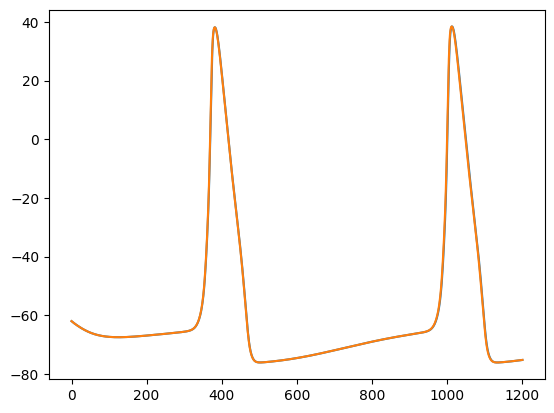

In [2108]:
plt.plot(voltages_neuron[0], label="neuron")
# plt.plot(voltages_jaxley_old[0], label="jaxley old")
plt.plot(voltages_jaxley[0], label="new")

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


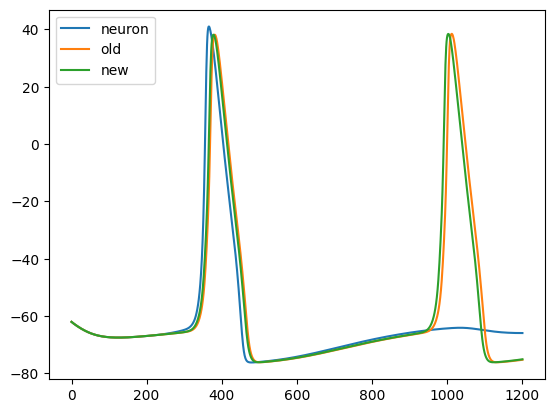

In [276]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

ncomp_per_branch = 3

neuron_swc_reader(fname)
comp_graph_neuron = neuron_comp_graph(ncomp=ncomp_per_branch)
cell_neuron = graph_io_new._build_module(comp_graph_neuron)

swc_graph_new = graph_io_new.swc_to_nx(fname)
comp_graph_new = graph_io_new.build_compartment_graph(swc_graph_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
cell_new = graph_io_new.from_graph(comp_graph_new)

cell_old = jx.read_swc(
    fname,
    ncomp=ncomp_per_branch,
    max_branch_len=2_000.0,
    assign_groups=True,
    backend="graph",
    ignore_swc_tracing_interruptions=False,
)

loc = 0.51
rec_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
rec_xyz = np.concatenate([cell_old.branch(i).loc(loc).nodes[["x", "y", "z"]].values for i in rec_inds])

stim_loc = 0.51
stim_xyz = cell_old.soma.branch(0).loc(stim_loc).nodes[["x", "y", "z"]].values
stimulus = jx.step_current(i_delay = 5.0, i_dur = 20.0, i_amp = 1.0, delta_t = 0.025, t_max = 30.0)

for cell in [cell_old, cell_neuron, cell_new]:
    cell.insert(HH())
    cell.set("axial_resistivity", 100.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)

    xyzs = cell.nodes[["x", "y", "z"]].values
    dists = cdist(xyzs, stim_xyz)
    idx = np.argmin(dists, axis=0)
    cell.select(idx).stimulate(stimulus)

    dists = cdist(xyzs, rec_xyz)
    rec_idxs = np.argmin(dists, axis=0)
    for i in rec_idxs:
        cell.select(i).record(verbose=False)

voltages_neuron = jx.integrate(cell_neuron, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_old = jx.integrate(cell_old, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_new = jx.integrate(cell_new, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

plt.plot(voltages_neuron[0], label="neuron")
plt.plot(voltages_old[0], label="old")
plt.plot(voltages_new[0], label="new")
plt.legend()

In [1569]:
fpath = "../jaxley/tests/swc_files"
fname = "morph_ca1_n120_250.swc"

swc_jaxley = graph_io_new.swc_to_nx(os.path.join(fpath, fname))

comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=3, max_len=2000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_jaxley)


In [ ]:
def to_graph(module):
    edges = module.edges.set_index(["pre_index", "post_index"])
    edges.index.names = (None, None)

    G = graph_io_new.pandas_to_nx(module.nodes, edges, pd.Series())

    global_attrs = ["xyzr", "channels", "synapses", "group_names", "branchpoints_and_tips"]
    for attr in global_attrs:
        G.graph[attr] = getattr(module, attr)

    G = graph_io_new._replace_edges_with_branchpoints(G) # TODO: fix this
    return G

def set_ncomp(cell, branch, ncomp):
    branch_xyzr = cell.xyzr[branch]
    node_df = pd.DataFrame(branch_xyzr, columns=["x", "y", "z", "r"])
    node_df["id"] = 0 # dummy id

    # assert no synapses attached to branch
    # assert attrs other than xyzr along branch are the same

    branch_comps = graph_io_new.compartmentalize_branch(node_df, ncomp)
    # TODO: Finish this

In [ ]:
def set_ncomp(view, ncomp):
    from jaxley.io.graph import branch_comps_from_nodes

    new_branch_comps = []
    for branch_idx in view._branches_in_view:
        branch = view.branch(branch_idx)
        node_attrs = pd.DataFrame(branch.xyzr[0], columns=["x", "y", "z", "r"])
        node_attrs["id"] = 0
        new_comps = branch_comps_from_nodes(node_attrs, ncomp)
        comp_cols = ["is_comp","id", "length", "x", "y", "z", "radius", "area", "volume"]
        comp_df = pd.DataFrame(new_comps, columns=comp_cols)
        comp_df = comp_df.loc[comp_df["is_comp"].astype(bool)].drop(columns=["id", "is_comp"])
        
        for name, is_group in branch.nodes[branch.group_names].all().items():
            comp_df.loc[:, name] = is_group

        comp_df["global_cell_index"] = branch.nodes["global_cell_index"].iloc[0]
        comp_df["global_branch_index"] = branch.nodes["global_branch_index"].iloc[0]
        comp_df["v"] = np.mean(branch.nodes["v"])
        comp_df["axial_resistivity"] = np.mean(branch.nodes["axial_resistivity"])
        comp_df["capacitance"] = np.mean(branch.nodes["capacitance"])
            
        comp_df.index = [-1]*len(comp_df.index)

        new_branch_comps.append(comp_df)

    for branch_idx, branch_comps in zip(view._branches_in_view, new_branch_comps):
        branch_nodes = view.nodes[view.nodes["global_branch_index"] == branch_idx].index
        view.base.nodes = pd.concat([view.base.nodes.loc[:branch_nodes[0]], branch_comps, view.base.nodes.loc[branch_nodes[-1]:]], ignore_index=True, join="outer")
    
    view.base.nodes["global_comp_index"] = np.arange(len(view.base.nodes))
    view.base._init_view()
    view.base._update_local_indices()
    

set_ncomp(cell.branch(0), 5)

In [640]:
swc_graph_old = graph_io_old.to_swc_graph(fname)
comp_graph_old = graph_io_old.build_compartment_graph(swc_graph_old, ncomp=1, max_len=1e-10)
test_cell = graph_io_old.from_graph(comp_graph_old)


In [641]:
print(len(swc_graph_old.nodes))
print(len(test_cell.nodes))

250
249
